Load libraries

In [77]:
library(here);
library(Distance); # for summarize_ds_models function
library(dsm) # for dsm_cor function
library(mrds)
library(mgcv); # for gam function   
library(dplyr)      # For data manipulation
library(ggplot2)
library(RColorBrewer);

Load data

In [115]:
# Set default figure size and resolution
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

# Define a colour palette
colour_palette <- brewer.pal(5, "RdBu")

# define list with WUM numbers
wmu_number_list <- c('501','503', '512', '517', '528')
wmu_number <- wmu_number_list[4]
# loop through WUM numbers
# for(wmu_number in wmu_number_list){

  # Load processed data
  input_path <- here("Output", "DSM", paste0("dsm",wmu_number,".RData"))
  load(file = input_path)

  # Assign individal names to data frames
  # assign(paste0("dsm_list_",wmu_number), dsm_list)
  # assign(paste0("detfc_list_bin_compact",wmu_number), detfc_list_bin_compact)
  # rm(dsm_list, detfc_list_bin_compact)
# }

remove_invalid_models <- function(model_list) {
  valid_models <- list()
  
  for (i in seq_along(model_list)) {
    model <- model_list[[i]]
    model_name <- names(model_list)[i]
    tryCatch({
      # Attempt to get the summary of the model
      model_summary <- summary(model)
      # If successful, add the model to the valid_models list with its name
      valid_models[[model_name]] <- model
    }, error = function(e) {
      # If an error occurs, print a message and skip the model
      message(sprintf("Model '%s' at index %d is invalid and will be removed: %s", model_name, i, e$message))
    })
  }
  
  return(valid_models)
}

# Use the function to filter the models
detfc_list_bin_compact <- remove_invalid_models(detfc_list_bin_compact)

Error in solve.default(m) : 
  system is computationally singular: reciprocal condition number = 4.68055e-17


Warning message in diag(vcov):
"NAs introduced by coercion"
Model 'detfc_cc_hn_null_trunc_0.55_bin_0.1' at index 9 is invalid and will be removed: invalid 'nrow' value (too large or NA)



Rank models

In [118]:
aic_values_bin <- purrr::map_dbl(detfc_list_bin_compact, ~ .x$ddf$criterion)
# Extract CV values for each model
cv_values_bin <- purrr::map_dbl(detfc_list_bin_compact, function(model) {
  model_summary <- summary(model)
  cv_value <- model_summary$ds$Nhat.se[1] / model_summary$ds$Nhat
  return(cv_value)
})

# Extract Chi-Square values for each model
chi_square_values_bin <- purrr::map_dbl(detfc_list_bin_compact, function(model) {
  gof_test <- ddf.gof(model$ddf)
  chi_square_value <- gof_test$chisquare$chi1$chisq
  return(chi_square_value)
})

# Combine AIC and CV values into a dataframe
model_metrics <- data.frame(
  Model = names(detfc_list_bin_compact),
  AIC = round(aic_values_bin,0),
  CV = round(cv_values_bin,3),
  Chi_Square = round(chi_square_values_bin,1)
)

# Normalise AIC and CV (assuming lower values are better)
model_metrics <- model_metrics %>%
  mutate(
    AIC_normalised = (AIC - min(AIC)) / (max(AIC) - min(AIC)),
    CV_normalised = (CV - min(CV)) / (max(CV) - min(CV)),
    Chi_Square_normalised = (Chi_Square - min(Chi_Square)) / (max(Chi_Square) - min(Chi_Square))
  )

# Define weights for AIC, CV and Chi-Square (adjust these weights according to your preference)
weight_AIC <- 1
weight_CV <- 0.5
weight_Chi_Square <- 0.5

# Combine the normalized values using the weights
model_metrics <- model_metrics %>%
  mutate(
    combined_score = weight_AIC * AIC_normalised + weight_CV * CV_normalised + weight_Chi_Square * Chi_Square_normalised
  ) %>%
  arrange(combined_score)

row.names(model_metrics) <- NULL;

In [119]:
knitr::kable(model_metrics, digits = 3, escape = FALSE, caption = "Model comparison metrics") # %>%
  # kable_styling(full_width = FALSE, position = "center")



Table: Model comparison metrics

|Model                              | AIC|       CV| Chi_Square| AIC_normalised| CV_normalised| Chi_Square_normalised| combined_score|
|:----------------------------------|---:|--------:|----------:|--------------:|-------------:|---------------------:|--------------:|
|detfc_hr_null_trunc_0.55_bin_0.1   | 437|    0.400|       13.9|          0.000|             0|                 0.000|          0.000|
|detfc_hn_cos_trunc_0.55_bin_0.1    | 445|    0.091|       23.5|          0.125|             0|                 0.298|          0.274|
|detfc_hr_null_trunc_0.6_bin_0.1    | 470|    0.413|       14.5|          0.516|             0|                 0.019|          0.525|
|detfc_hn_cos_trunc_0.6_bin_0.1     | 479|    0.089|       22.5|          0.656|             0|                 0.267|          0.790|
|detfc_hn_null_trunc_0.55_bin_0.1   | 459|    0.075|       46.1|          0.344|             0|                 1.000|          0.844|
|detfc_cc_hr_null_tr

In [120]:
# Select items containing 'trunc_0.6'
detfc_list_trunc_0.6 <- grep("trunc_0.6", detfc_list_bin_compact)

# Select items not containing 'trunc_0.6'
detfc_list_trunc_99 <- grep("trunc_0.6", detfc_list_bin_compact, invert = TRUE)

# for (wmu_number in wmu_number_list){
  table_ds_models_trunc_0.6 <- do.call(summarize_ds_models, detfc_list_bin_compact[detfc_list_trunc_0.6])
  table_ds_models_trunc_99 <- do.call(summarize_ds_models, detfc_list_bin_compact[detfc_list_trunc_99])


In [121]:
  knitr::kable(table_ds_models_trunc_0.6[, -1], digits=3, escape=FALSE,
             caption="Model selection summary of the 600m truncation models") # %>%
  # kable_styling(full_width = FALSE, position = "center")
  knitr::kable(table_ds_models_trunc_99[, -1], digits=3, escape=FALSE,
              caption="Model selection summary of the 99.5 percentile truncation models") # %>%
  # kable_styling(full_width = FALSE, position = "center")
  # }



Table: Model selection summary of the 600m truncation models

|   |Key function                                       |Formula                  | $\chi^2$ $p$-value| $\hat{P_a}$| se($\hat{P_a}$)| $\Delta$AIC|
|:--|:--------------------------------------------------|:------------------------|------------------:|-----------:|---------------:|-----------:|
|1  |Hazard-rate                                        |~1                       |              0.002|       0.187|           0.076|       0.000|
|3  |Half-normal with cosine adjustment term of order 2 |~1                       |              0.000|       0.314|           0.020|       9.389|
|5  |Half-normal                                        |~as.factor(canopy_cover) |                 NA|       0.151|         740.151|      28.773|
|2  |Half-normal                                        |~1                       |              0.000|       0.413|           0.019|      29.755|
|4  |Hazard-rate                                      



Table: Model selection summary of the 99.5 percentile truncation models

|   |Key function                                       |Formula | $\chi^2$ $p$-value| $\hat{P_a}$| se($\hat{P_a}$)| $\Delta$AIC|
|:--|:--------------------------------------------------|:-------|------------------:|-----------:|---------------:|-----------:|
|1  |Hazard-rate                                        |~1      |              0.001|       0.207|           0.082|       0.000|
|3  |Half-normal with cosine adjustment term of order 2 |~1      |              0.000|       0.327|           0.021|       7.786|
|2  |Half-normal                                        |~1      |              0.000|       0.413|           0.020|      21.672|

Plot detection functions

[1] "The best model is: detfc_hr_null_trunc_0.55_bin_0.1"


Last interval endpoint did not include 0.55. It was reset.

Last interval endpoint did not include 0.55. It was reset.

Last interval endpoint did not include 0.55. It was reset.



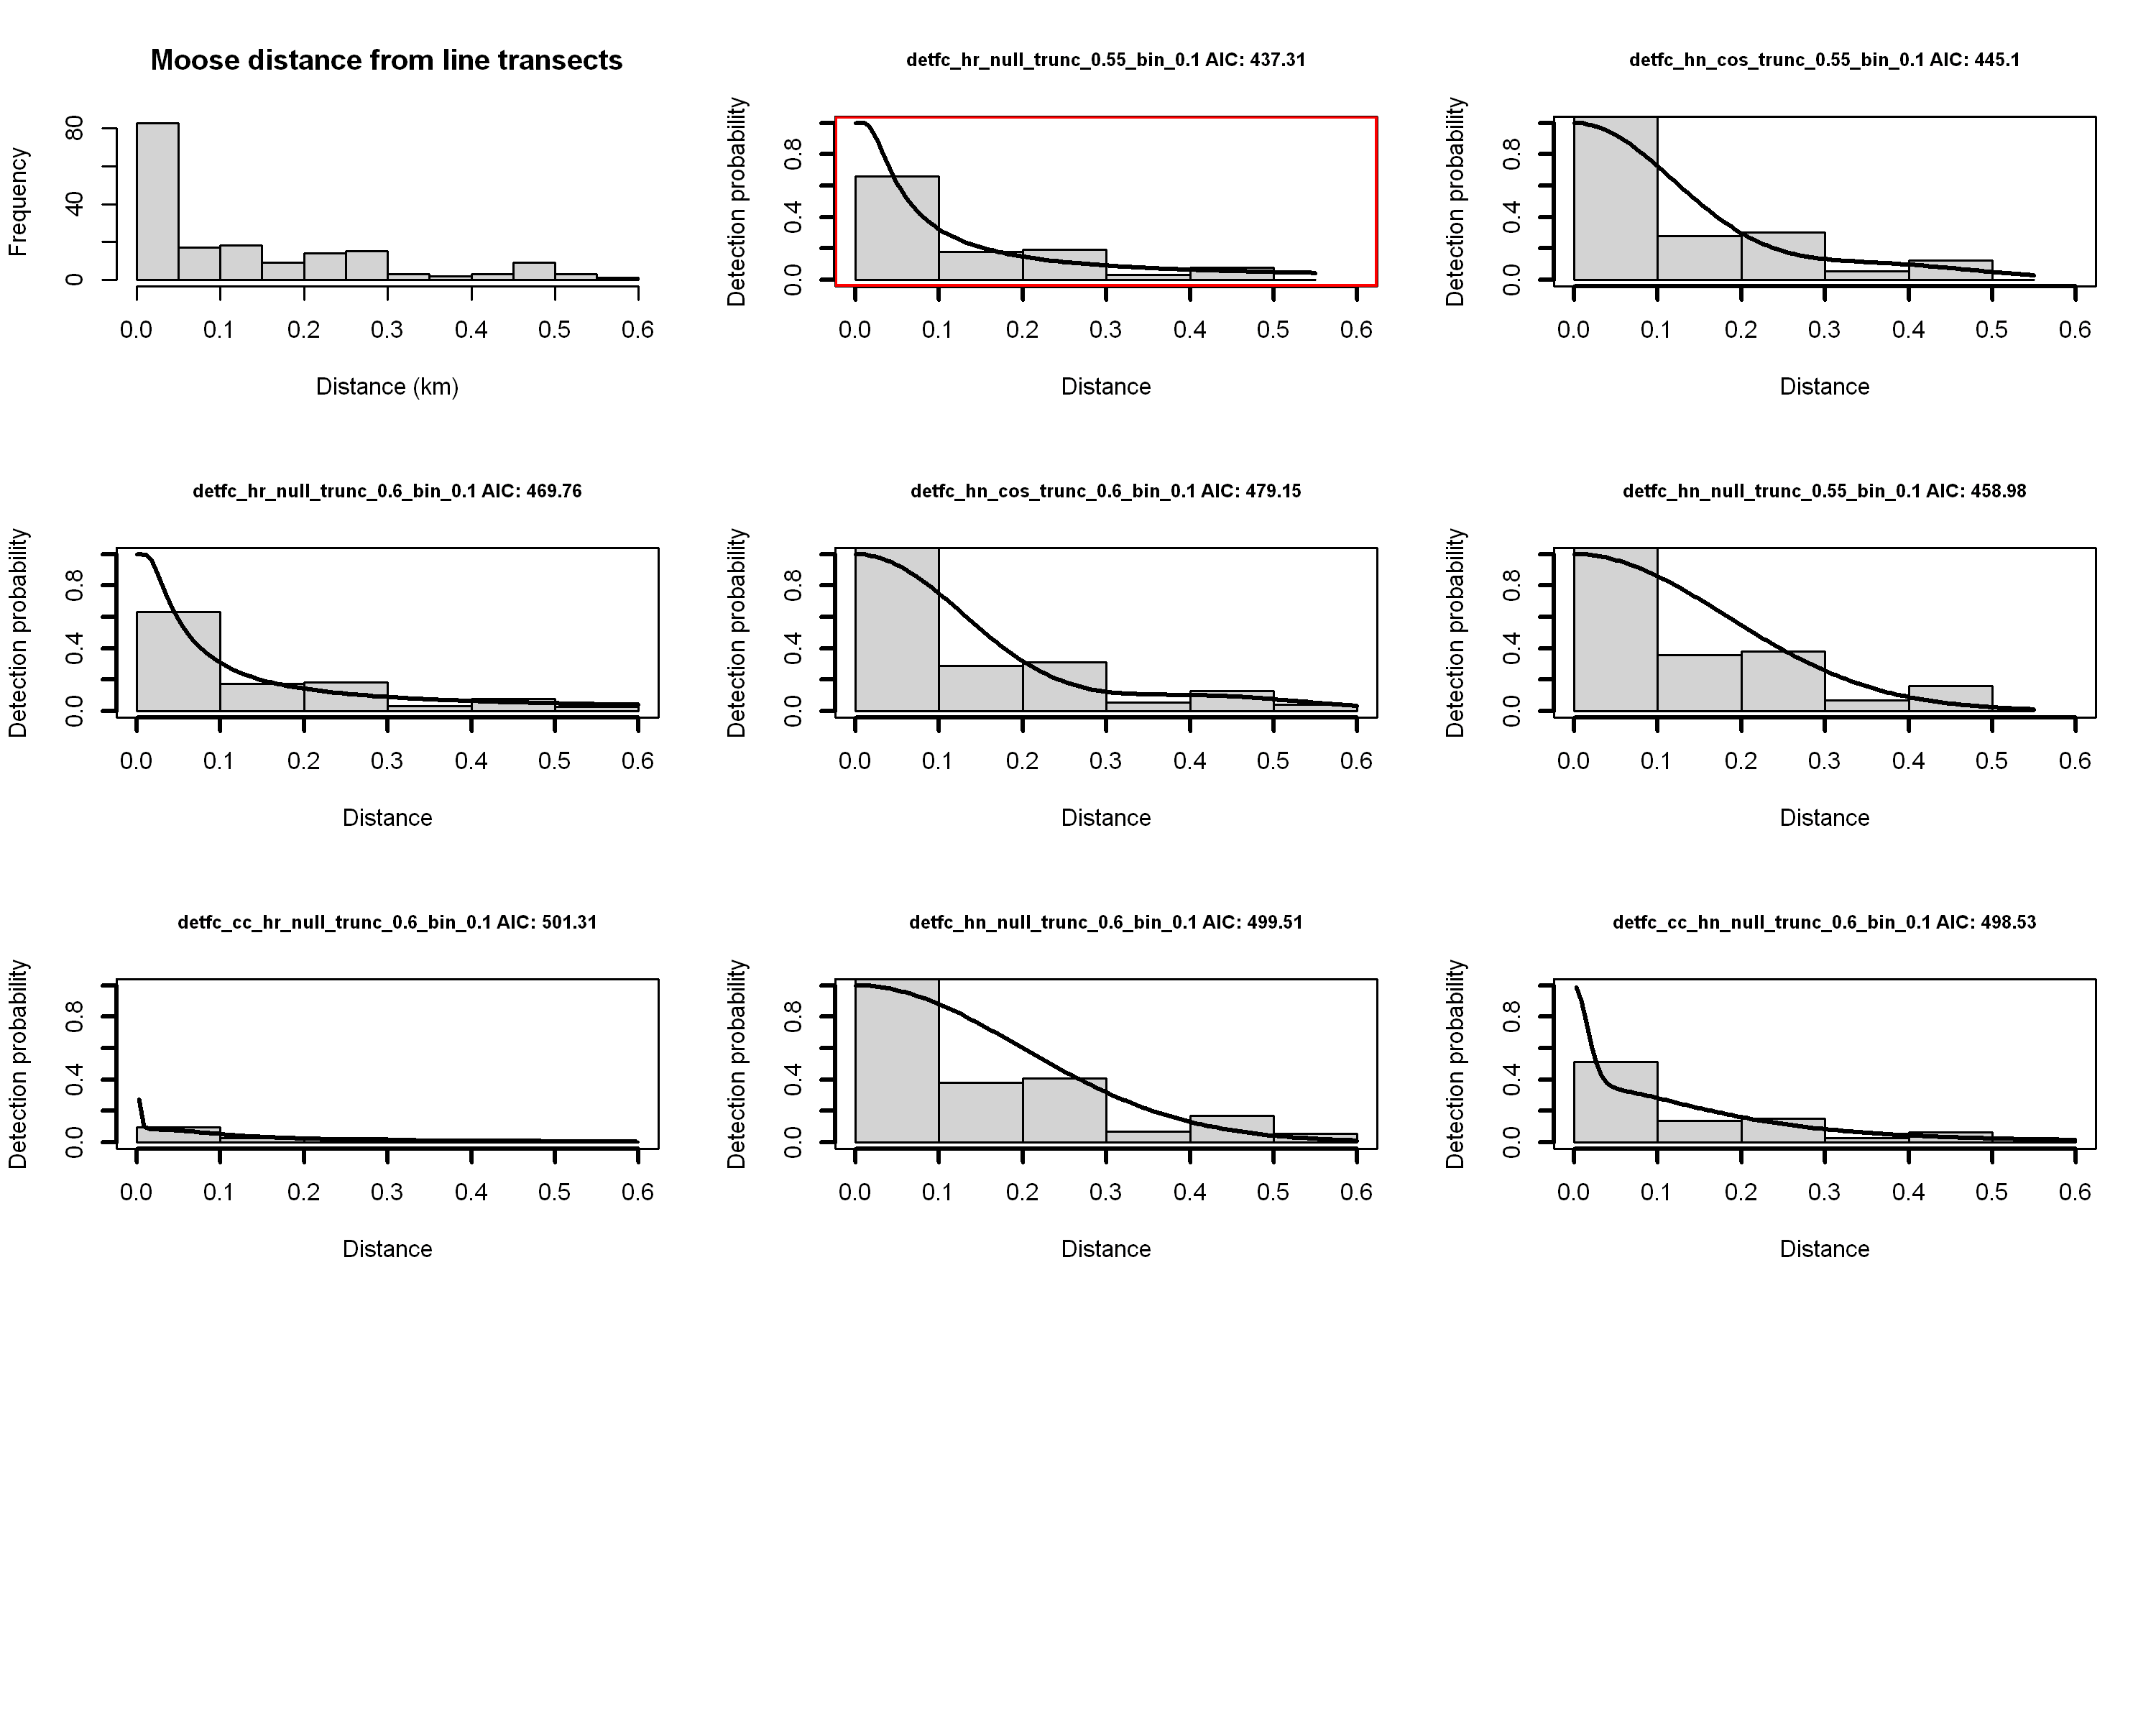

In [122]:
# select best model
best_model <- detfc_list_bin_compact[[model_metrics$Model[1]]]
print(paste0("The best model is: ", model_metrics$Model[1]))
# Plot the models
par(mfrow = c(4, 3)) # adjust based on the number of models +1
break_bins <- seq(from = 0, to = 0.6, by = 0.05)
hist(distdata$distance, main = "Moose distance from line transects", xlab = "Distance (km)", breaks = break_bins)
for (model_name in model_metrics$Model) {
  model <- detfc_list_bin_compact[[model_name]]
  # Check if the current model is the best model
  if (model_name == model_metrics$Model[1]) {
    plot(model, showpoints = FALSE, pl.den = 0, lwd =2, xlim = c(0,0.6), ylim = c(0,1), main = paste(model_name, "AIC:", round(model$ddf$criterion,2)))
    # Draw a red box around the plot
    usr <- par("usr")
    rect(usr[1], usr[3], usr[2], usr[4], border = "red", lwd = 2)
  } else {
    plot(model, showpoints = FALSE, pl.den = 0, lwd = 2, xlim = c(0,0.6), ylim = c(0,1), main = paste(model_name, "AIC:", round(model$ddf$criterion,2)))
  }
  # ddf.gof(model$ddf, qq = TRUE, main = model_name)
}
par(mfrow = c(1, 1))


plot best model

Last interval endpoint did not include 0.55. It was reset.



1,0,0.5780347
2,0,0.5780347
4,0,0.5780347
6,0,0.5780347
8,0,0.5780347
10,0,0.5780347
12,0,0.5780347
14,0,0.5780347
16,0,0.5780347
18,0,0.5780347
20,0,0.5780347


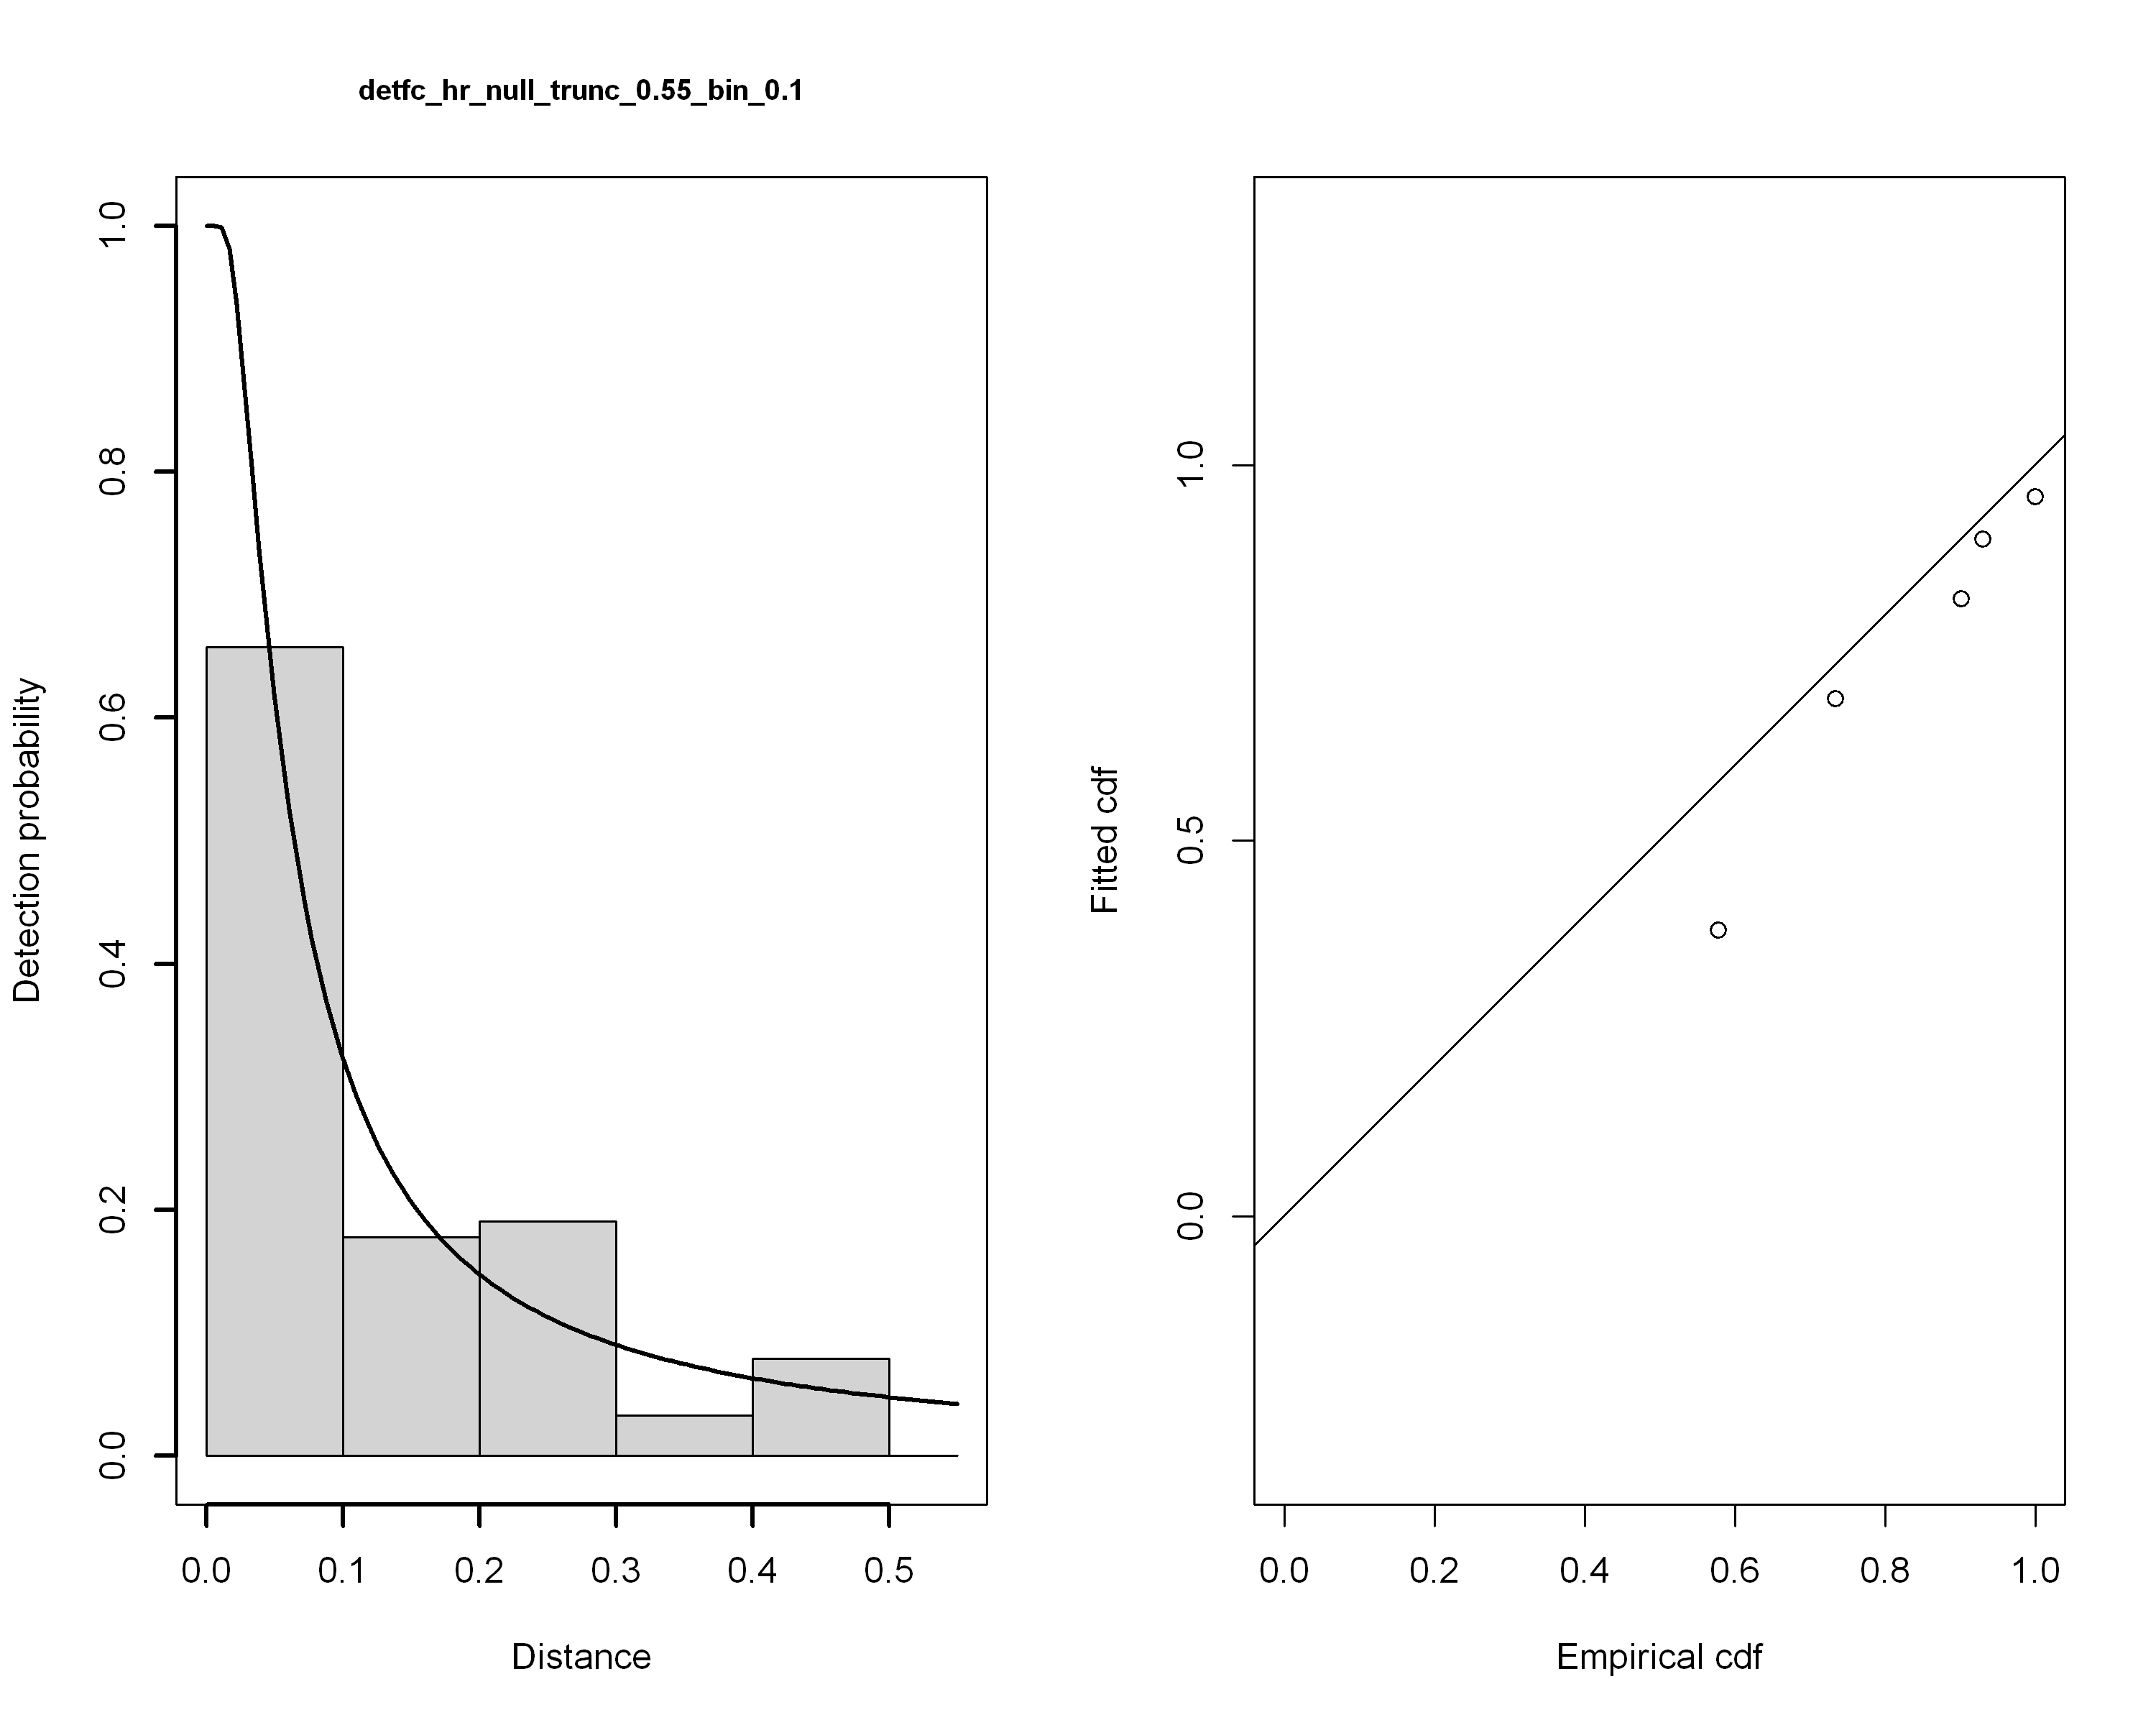

In [123]:
par(mfrow = c(1, 2))
plot(best_model, showpoints = FALSE, pl.den = 0, lwd = 2, ylim = c(0,1), main = model_metrics$Model[1])
qqplot.ddf(best_model$ddf)
par(mfrow = c(1, 1))


Plot DSM

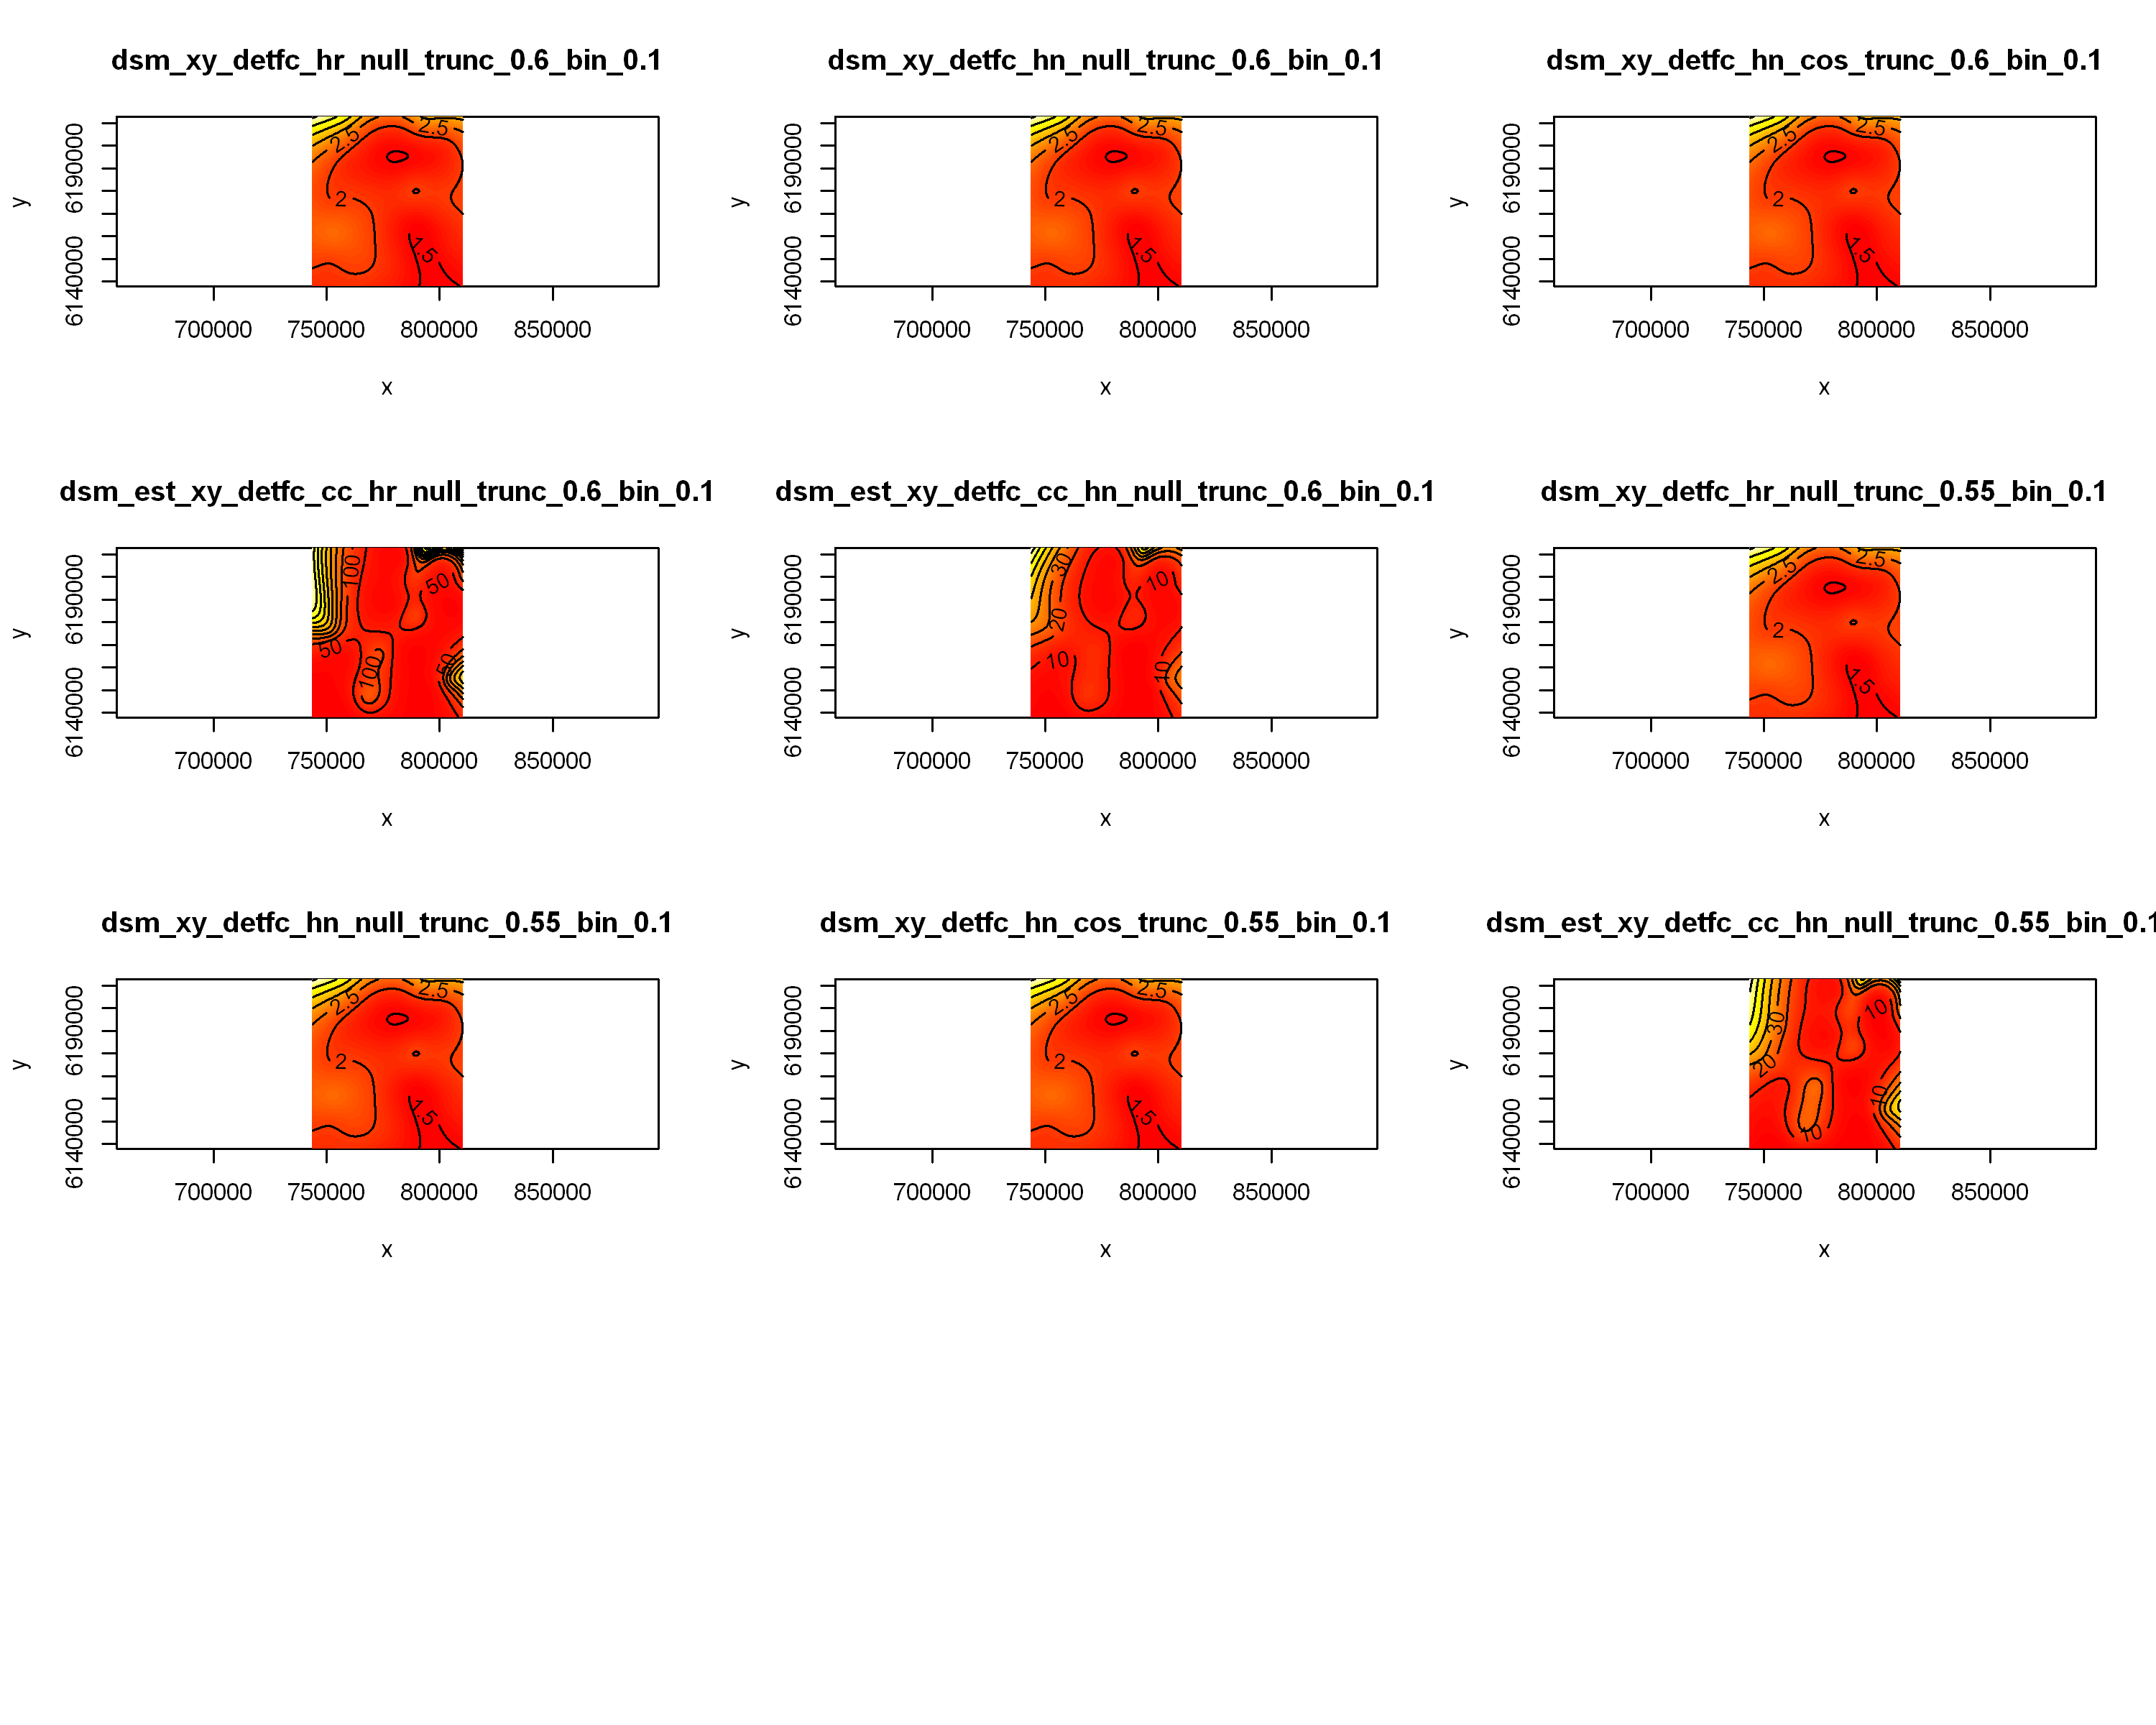

In [124]:
# Call summary and plot for each detection function after the loop
par(mfrow = c(4, 3))
for (model_name in names(dsm_list)) {
 dsm_model <- dsm_list[[model_name]]
 vis.gam(dsm_model, plot.type = "contour", view = c("x", "y"), asp = 1, type = "response", contour.col = "black", n.grid = 500, main = model_name)
}
par(mfrow = c(1, 1))

Check autocorrelation

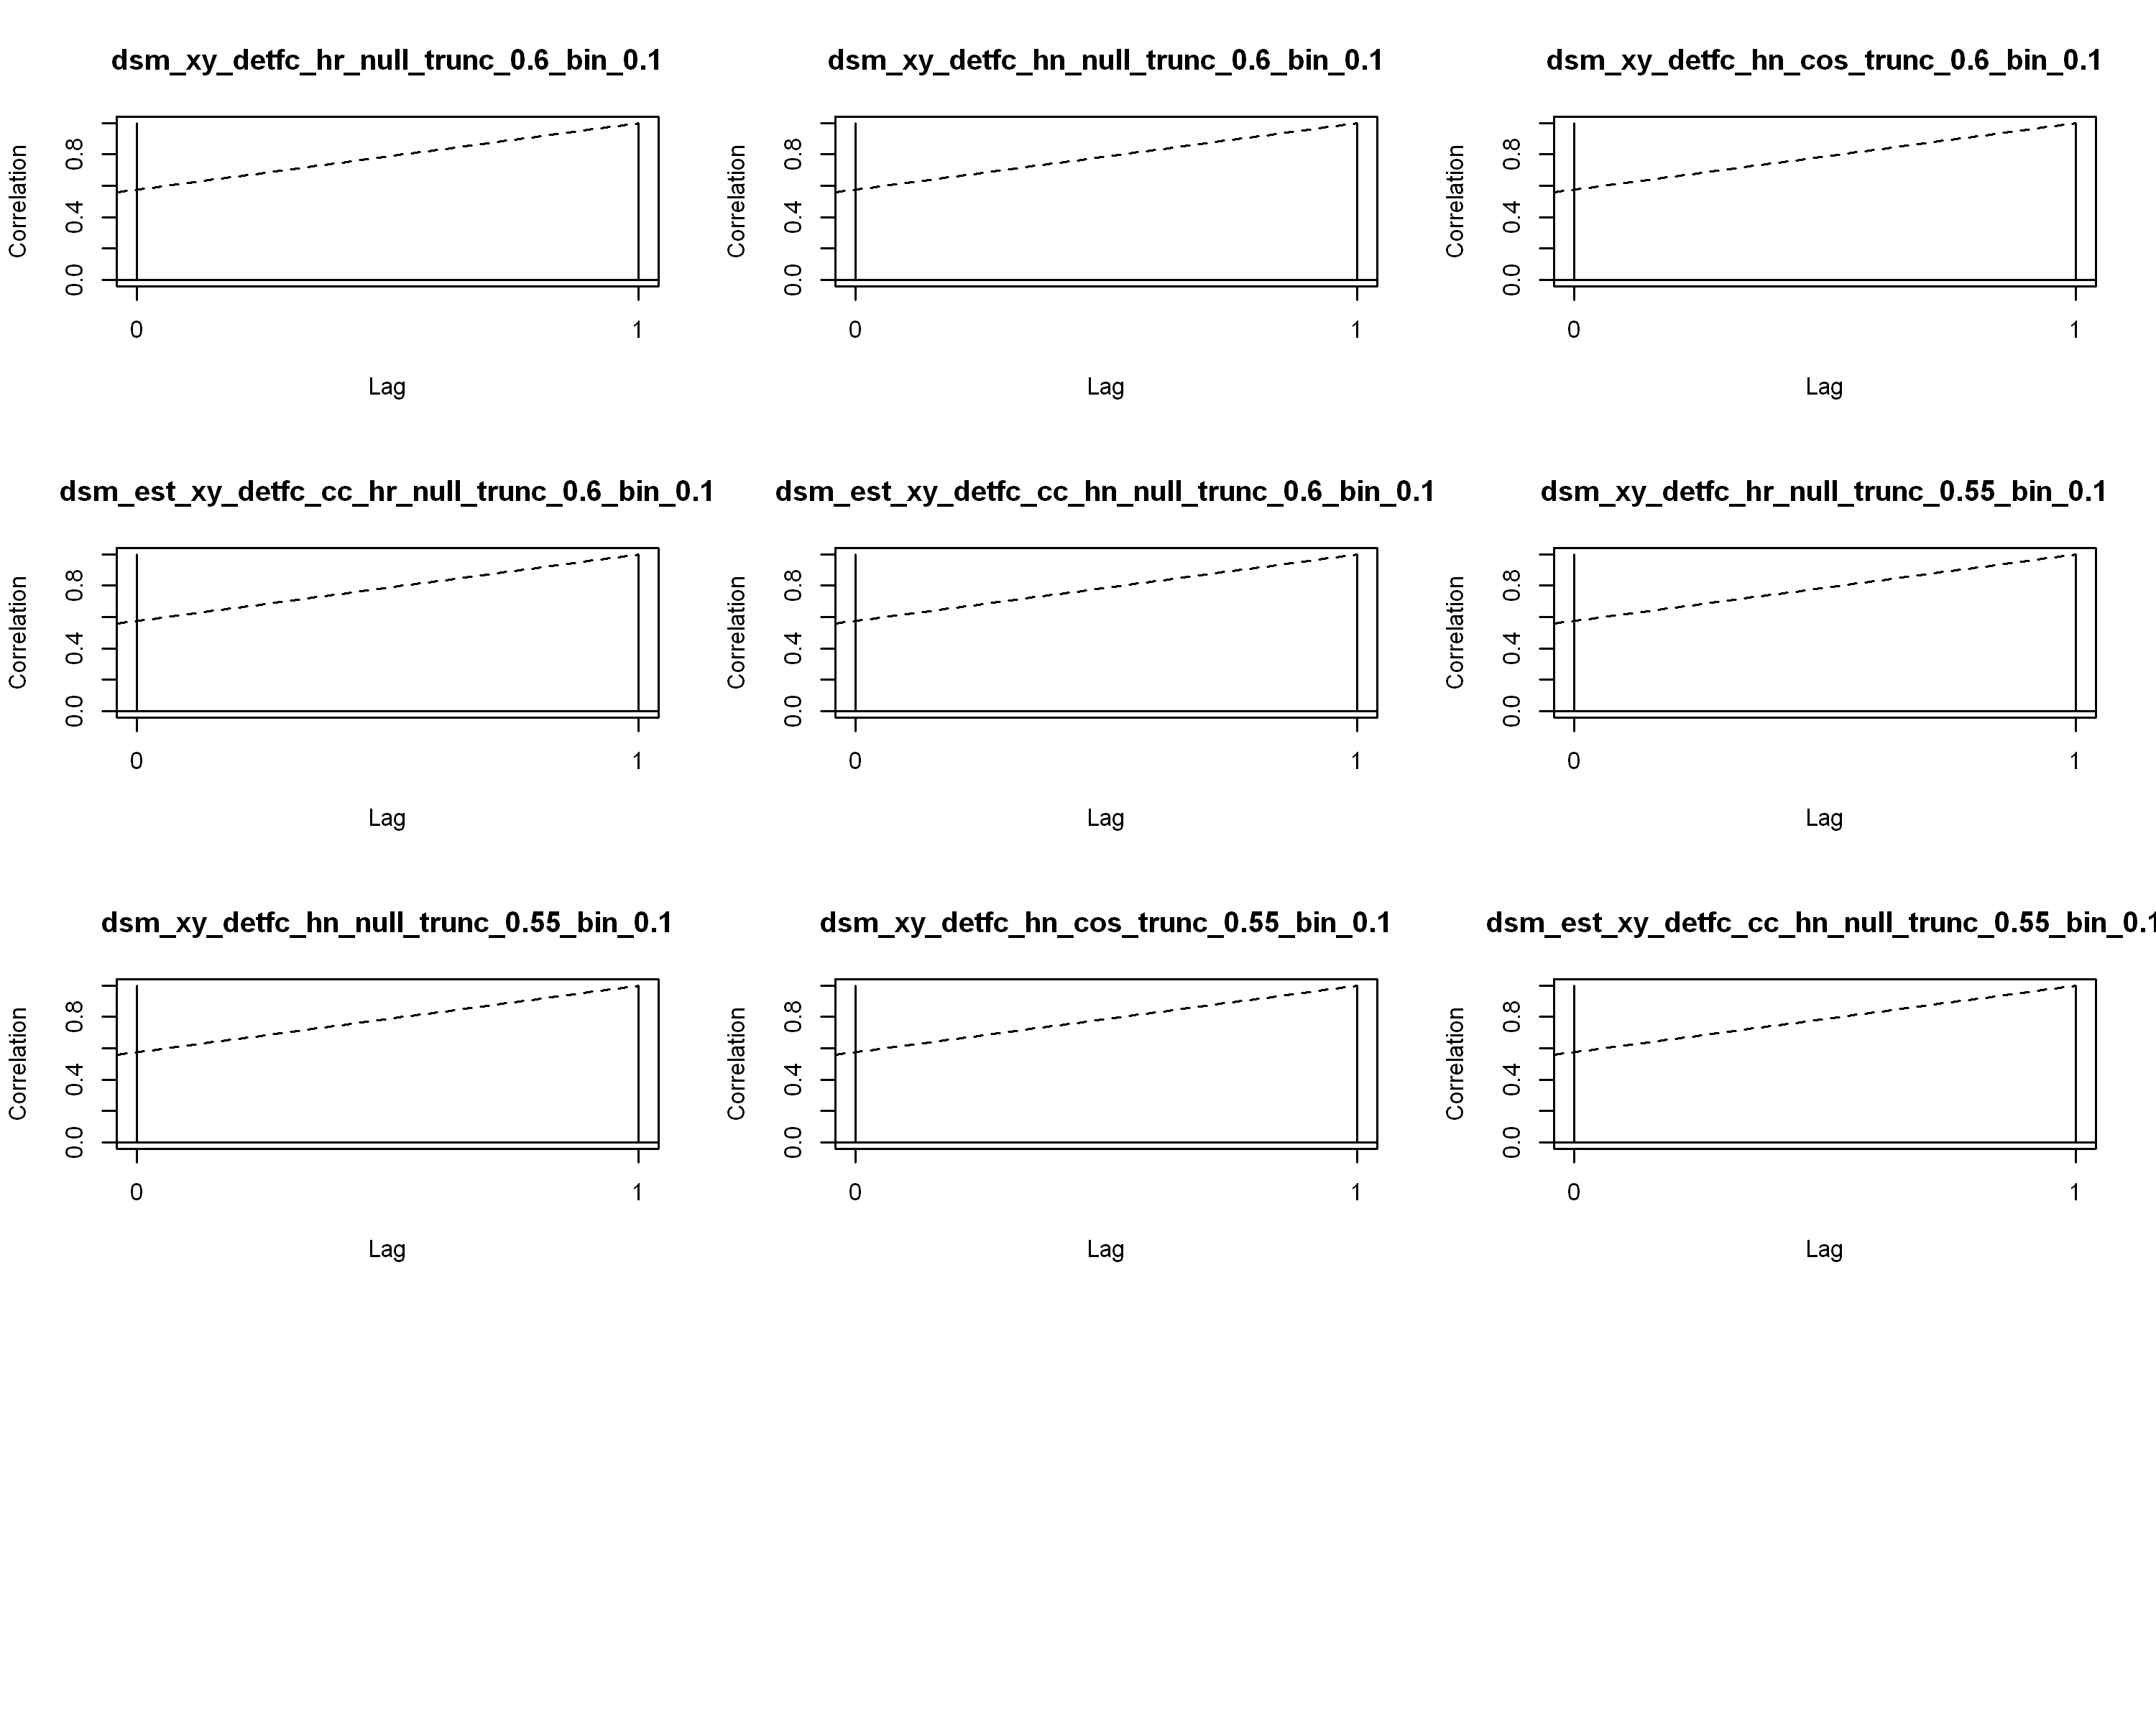

In [125]:
# Check for autocorrelation
par(mfrow = c(4, 3))
for (i in 1:length(dsm_list)) {
  dsm_cor(dsm_list[[i]], max.lag = 6, Segment.Label = "Sample.Label", main = names(dsm_list)[[i]])
}
par(mfrow = c(1, 1))

Check goodness of fit with Q-Q plots


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-5.237979e-10,4.216894e-11]
(score -37.22621 & scale 0.1798896).
Hessian positive definite, eigenvalue range [3.033077,87.58743].
Model rank =  30 / 30 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

         k'  edf k-index p-value    
s(x,y) 29.0 16.1    0.74  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
[1] "dsm_xy_detfc_hn_null_trunc_0.55_bin_0.1"


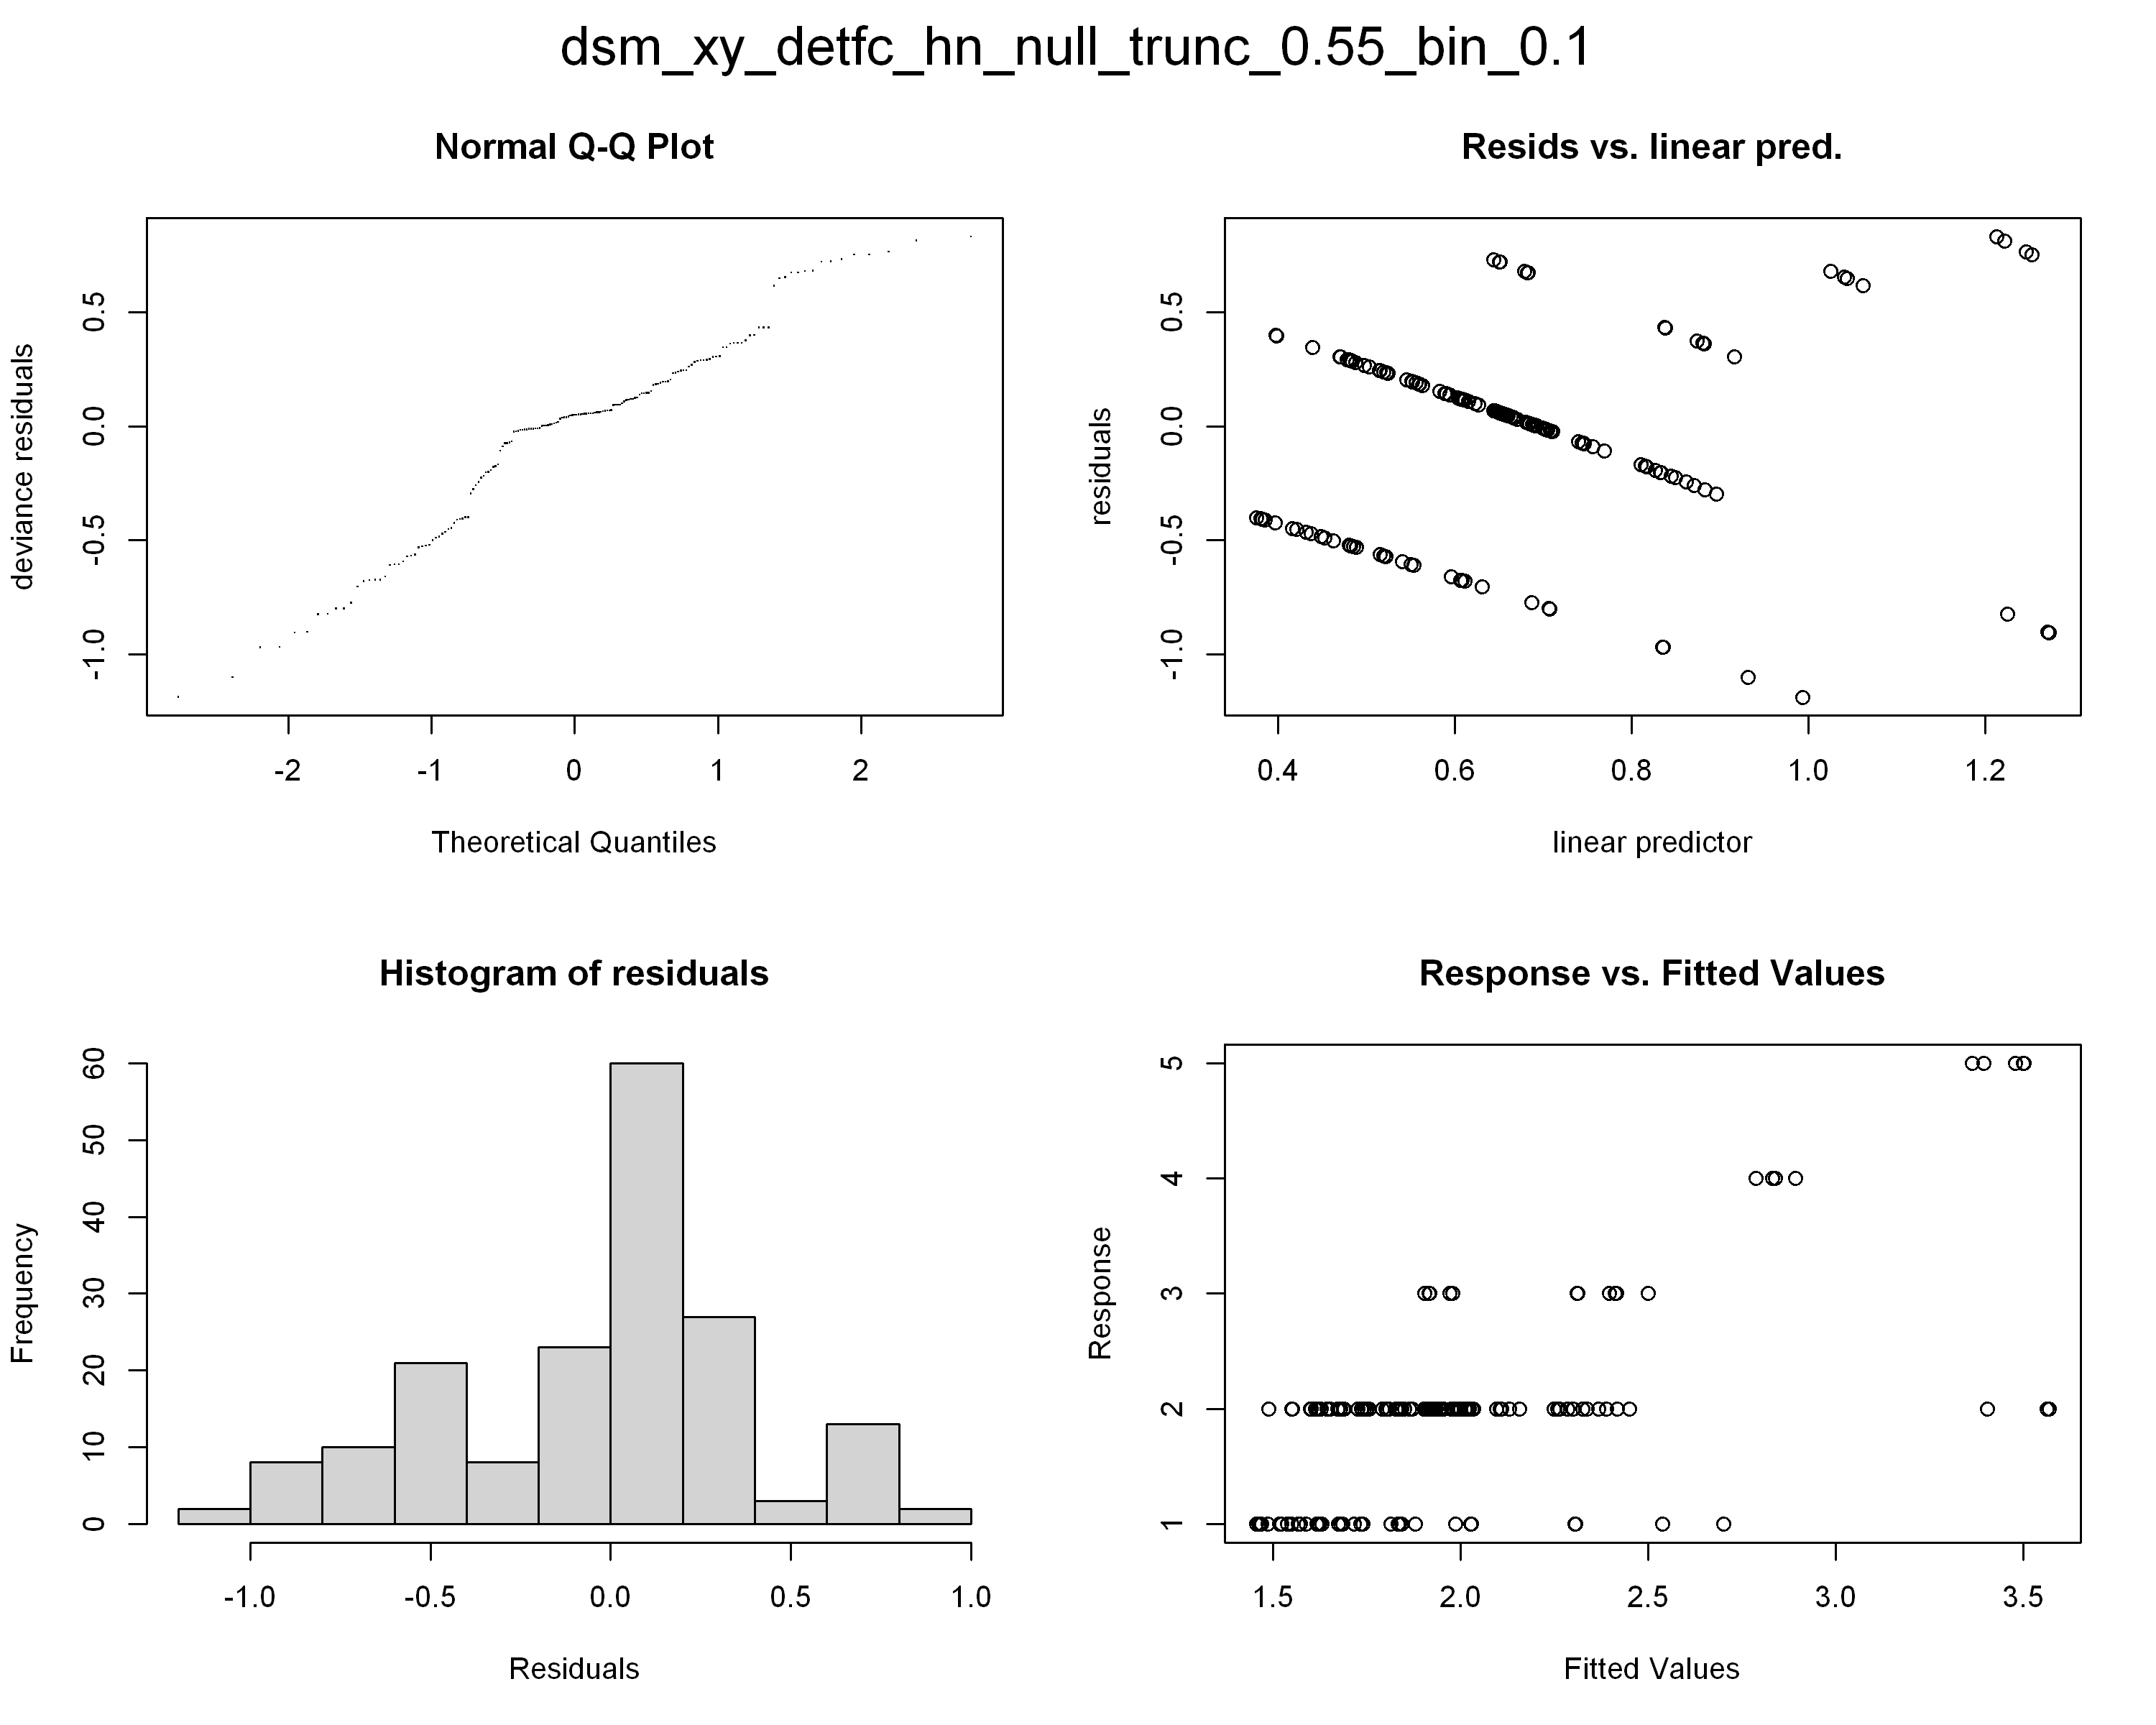

In [126]:

par(mfrow = c(2, 2), oma = c(0, 0, 2, 0))
  model <- dsm_list[[7]]
  gam.check(model)
  # Add a title to the entire plotting area
  print(model$name)
  mtext(model$name, outer = TRUE, cex = 1.5)

par(mfrow = c(1, 1))




Summarise model results

In [127]:

mod_results <- data.frame(
  "Deviance explained" = sapply(
    dsm_list,
    function(x) paste0(round(summary(x)$dev.expl * 100, 2), "%")
  )
)

knitr::kable(mod_results, col.names = c("Model name", "Deviance explained"))




|Model name                                     |Deviance explained |
|:----------------------------------------------|:------------------|
|dsm_xy_detfc_hr_null_trunc_0.6_bin_0.1         |40.79%             |
|dsm_xy_detfc_hn_null_trunc_0.6_bin_0.1         |40.79%             |
|dsm_xy_detfc_hn_cos_trunc_0.6_bin_0.1          |40.79%             |
|dsm_est_xy_detfc_cc_hr_null_trunc_0.6_bin_0.1  |43.34%             |
|dsm_est_xy_detfc_cc_hn_null_trunc_0.6_bin_0.1  |47.67%             |
|dsm_xy_detfc_hr_null_trunc_0.55_bin_0.1        |40.79%             |
|dsm_xy_detfc_hn_null_trunc_0.55_bin_0.1        |40.79%             |
|dsm_xy_detfc_hn_cos_trunc_0.55_bin_0.1         |40.79%             |
|dsm_est_xy_detfc_cc_hn_null_trunc_0.55_bin_0.1 |47.63%             |